#Install Library

In [11]:
!pip install sastrawi

     |████████████████████████████████| 209 kB 5.3 MB/s 


#Data Cleaning
* Melakukan prapemrosesan pada suatu kalimat dengan menghilangkan formatting pada kalimat
* Menghilangkan stopword pada kalimat, mengganti kata alay yang sudah terdefinisikan
* Serta melakukan stemming kalimat tersebut

In [12]:
import pandas as pd
import re
import string
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

class DataCleaning:
  # Initialization
  factory     = StemmerFactory()
  stemmer     = factory.create_stemmer()
  kamus_alay1 = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/Kamus-Alay/main/Kamu-Alay.csv')
  kamus_alay1 = kamus_alay1.set_index('kataAlay')
  kamus_alay2 = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
  kamus_alay2 = kamus_alay2.filter(['slang', 'formal'], axis=1)
  kamus_alay2 = kamus_alay2.drop_duplicates(subset=['slang'], keep='first')
  kamus_alay2 = kamus_alay2.set_index('slang')
  stopword   = list(pd.read_csv('https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt', header = None)[0])

  @classmethod
  def CleanDataFrame(cls, df, col_name, label_name, minimum_kata=0, label_mapping=None, dropna=False, stem=False, stop=False):

    final_list_clean = []
    final_list_kotor = []
    final_label = []

    i = 0
    current = 0
    
    while i < len(df):
      current_kalimat = str(df.iloc[i][col_name])
      current_label = df.iloc[i][label_name]

      clean_kalimat = cls.__cleanSentence__(current_kalimat, stem, stop)
      if type(clean_kalimat) != str or clean_kalimat == None or clean_kalimat == "":
        clean_kalimat = ""
      if (len(clean_kalimat.split(' ')) >= minimum_kata):
        final_list_clean.append(str(clean_kalimat))
        final_list_kotor.append(str(current_kalimat))
        if label_mapping != None:
          final_label.append(label_mapping[current_label])
        else:
          final_label.append(current_label)
        current += 1

      if i % 5000 == 0:
        print("Memproses {} data".format(i))
      i += 1
    
    data = {
        'raw': final_list_kotor,
        'processed': final_list_clean,
        'label': final_label
    }

    final_df = pd.DataFrame(data)
    if dropna:
      final_df.dropna(inplace=True)
    
    print("Hasil cleaning: {} data".format(len(final_df.index)))

    final_df['processed'] = final_df['processed'].astype(str)
    final_df['raw'] = final_df['raw'].astype(str)
    return final_df

  @classmethod
  def __cleanSentence__(cls, text, stem, stop):

    temp_text = list(text)
    for i in range(len(temp_text)):
      if temp_text[i] in string.punctuation:
        temp_text[i] = " "

    text = ''.join(temp_text)

    #will consider only alphabets
    text = re.sub('[^a-zA-Z]',' ',text) 
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will repalce repated char
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace space more than one
    text = re.sub('(s{2,})',' ',text)
    # will join the words
    text=' '.join(text.split())

    # unformal word to formal
    text_split = text.split(' ')
    for i in range(len(text_split)):
      if text_split[i] in cls.kamus_alay1.index:
        text_split[i] = cls.kamus_alay1.loc[text_split[i]]['kataBaik']
      elif text_split[i] in cls.kamus_alay2.index:
        text_split[i] = cls.kamus_alay2.loc[text_split[i]]['formal']

    # remove stopword
    if stop:
      temp_text_split = []
      for i in range(len(text_split)):
        if (text_split[i] not in cls.stopword):
          temp_text_split.append(text_split[i])

      final_text = ' '.join(temp_text_split)
    else:
      final_text = ' '.join(text_split)

    if stem: return cls.stemmer.stem(final_text)
    else: return final_text

#Load Data
* Data review seluruh produk Unilever dan Nestle dari Tokopedia
* Deklarasi nama kolom
* Casting tipe data

In [13]:
import pandas as pd

data = pd.read_csv("data_original.csv", names=['product_id', 'review', 'rating'], header=None, lineterminator='\n')

data['product_id'] = data['product_id'].astype(int)
data['review'] = data['review'].astype("string")
data['rating'] = data['rating'].astype(int)

data

,product_id,review,rating
0,611592417,NO COMENT,1
1,611592417,Lama banget; tumben Unilever slow respon; tolo...,1
2,611592417,paket tidak saya terima; saya kecewa karena pa...,1
3,611592417,minta dicancel; chat sudah dibaca tpi tetap di...,1
4,611592417,Lamban sekali pengiriman nya,1
...,...,...,...
125422,2201006015,<NA>,5
125423,2201006015,<NA>,5
125424,2201006015,<NA>,5
125425,2201006015,<NA>,5


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125427 entries, 0 to 125426
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   product_id  125427 non-null  int64 
 1   review      72279 non-null   string
 2   rating      125427 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 2.9 MB


# Handling Missing Value


*   Drop missing value 
*   Drop duplicates data



In [15]:
data.dropna(inplace=True)
data.drop_duplicates(subset=['product_id', 'review', 'rating'], keep='last', inplace=True)
data.shape

(59785, 3)

# Set sentiment value


*   Negative for rating 1,2,3
*   Positive for rating 4,5



In [16]:
def sentiment(x):
 if x <= 3: return(0)
 return(1)

data['sentiment'] = data['rating'].apply(sentiment)
data.head()

,product_id,review,rating,sentiment
50,611592417,NO COMENT,1,0
51,611592417,Lama banget; tumben Unilever slow respon; tolo...,1,0
52,611592417,paket tidak saya terima; saya kecewa karena pa...,1,0
53,611592417,minta dicancel; chat sudah dibaca tpi tetap di...,1,0
54,611592417,Lamban sekali pengiriman nya,1,0


# Perform data cleaning

In [17]:
data_clean = DataCleaning.CleanDataFrame(df = data, col_name='review', label_name='sentiment', dropna=True, minimum_kata=3, stem=True, stop=False)
data_clean

Memproses 0 data
Memproses 5000 data
Memproses 10000 data
Memproses 15000 data
Memproses 20000 data
Memproses 25000 data
Memproses 30000 data
Memproses 35000 data
Memproses 40000 data
Memproses 45000 data
Memproses 50000 data
Memproses 55000 data
Hasil cleaning: 48003 data


,raw,processed,label
0,Lama banget; tumben Unilever slow respon; tolo...,lama banget tumben unilever slow respon tolong...,0
1,paket tidak saya terima; saya kecewa karena pa...,paket tidak saya terima saya kecewa karena pak...,0
2,minta dicancel; chat sudah dibaca tpi tetap di...,minta dicancel chat sudah baca tapi tetap di p...,0
3,Lamban sekali pengiriman nya,lamban sekali kirim nya,0
4,Packaging yg dilakukan oleh pihak penjual sang...,packaging yang laku oleh pihak jual sangat kec...,0
...,...,...,...
47998,semua produk favorite 😁 terimakasih ya. sangat...,semua produk favorite terimakasih iya sangat m...,1
47999,Suka deh sama bundle kaya gini; makasih seller,suka deh sama bundle kayak begini terima kasih...,1
48000,sesuai deskripsi; admin responsif.,sesuai deskripsi admin responsif,1
48001,expirednya paling cepat tahun 2022. jadi worth...,expirednya paling cepat tahun jadi nila untuk ...,1


# Write data clean

In [18]:
data_clean.to_csv('data_clean.csv', index=False)

In [19]:
import pandas as pd

data_clean = pd.read_csv("data_clean.csv", lineterminator='\n')

data_clean['raw'] = data_clean['raw'].astype("string")
data_clean['processed'] = data_clean['processed'].astype("string")
data_clean['label'] = data_clean['label'].astype(int)

data_clean

,raw,processed,label
0,Lama banget; tumben Unilever slow respon; tolo...,lama banget tumben unilever slow respon tolong...,0
1,paket tidak saya terima; saya kecewa karena pa...,paket tidak saya terima saya kecewa karena pak...,0
2,minta dicancel; chat sudah dibaca tpi tetap di...,minta dicancel chat sudah baca tapi tetap di p...,0
3,Lamban sekali pengiriman nya,lamban sekali kirim nya,0
4,Packaging yg dilakukan oleh pihak penjual sang...,packaging yang laku oleh pihak jual sangat kec...,0
...,...,...,...
47998,semua produk favorite 😁 terimakasih ya. sangat...,semua produk favorite terimakasih iya sangat m...,1
47999,Suka deh sama bundle kaya gini; makasih seller,suka deh sama bundle kayak begini terima kasih...,1
48000,sesuai deskripsi; admin responsif.,sesuai deskripsi admin responsif,1
48001,expirednya paling cepat tahun 2022. jadi worth...,expirednya paling cepat tahun jadi nila untuk ...,1


#Visualize data clean

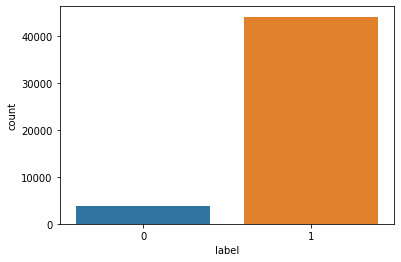

In [20]:
import seaborn as sns
ax = sns.countplot(x="label", data=data_clean)

# Handling Imbalance Data (Undersampling)




In [21]:
from sklearn.utils import shuffle

data_clean_0 = data_clean[data_clean["label"] == 0]
data_clean_1 = data_clean[data_clean["label"] == 1]

min_data = min([len(data_clean_0), len(data_clean_1)])
data_balanced = pd.concat([data_clean_0.sample(min_data), data_clean_1.sample(min_data)])

data_balanced

,raw,processed,label
14,Pengiriman super lama dan salah; lalu yang dik...,kirim super lama dan salah lalu yang kirim ada...,0
47936,kali ini jabodetabek terproses 6hari,kali ini jabodetabek proses hari,0
47421,Beli tgl 21 Juni; tertera di app akan sampe tg...,beli tanggal juni tera di app akan sampai tang...,0
27,satunya 940 Ml;; satunya cuma 670 Ml...padahal...,satu ml satu cuma ml padahal official store,0
44169,Expire date sisa 8 bln aja; mepet. Proses sell...,expire date sisa bulan saja dekat sekali prose...,0
...,...,...,...
13950,kualitas produk sangat baik packaging aman pen...,kualitas produk sangat baik packaging aman kir...,1
45316,pengiriman sangat cepat..tengah mlm pesan;sore...,kirim sangat cepat tengah malam pesan sore sud...,1
36561,kardusnya penyok tapi dalam aman utuh tidak bo...,kardus penyok tapi dalam aman utuh tidak bocor,1
47072,Puas dengan produk cuma mungkin pengemasan aga...,puas dengan produk cuma mungkin emas agak lebi...,1


# Visualize balanced data

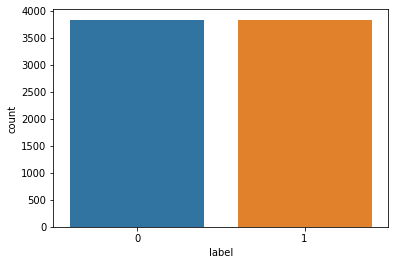

In [22]:
import seaborn as sns
ax = sns.countplot(x="label", data=data_balanced)

# Write data balanced

In [23]:
data_balanced.to_csv('data_balanced.csv', index=False)

# Tokenizer data

In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(data_balanced['processed'].values)

print('Found %s total vocabulary.' % len(tokenizer.word_index))

Found 4629 total vocabulary.


In [25]:
# saving tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=2)

In [26]:
X = tokenizer.texts_to_sequences(data_balanced['processed'].values)

In [27]:
print("Max sentence length: ", max([len(sen) for sen in X]))

Max sentence length:  193


# Set X and Y variabel


*   X from data tokenizer with max words= 50
*   Y from sentiment label



In [28]:
from keras.preprocessing.sequence import pad_sequences

max_words = 50
X = pad_sequences(X, maxlen = max_words, padding = 'post')

print('Shape of data tensor: ', X.shape)

Y = pd.get_dummies(data_balanced['label']).values

print('Shape of label tensor: ', Y.shape)

Shape of data tensor:  (7664, 50)
Shape of label tensor:  (7664, 2)


# Data splitting

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state=42)

print('Shape of data tensor of train: ', X_train.shape)
print('Shape of data tensor of test: ', X_test.shape)
print('Shape of label tensor of train: ', Y_train.shape)
print('Shape of label tensor of test: ', Y_test.shape)

Shape of data tensor of train:  (6897, 50)
Shape of data tensor of test:  (767, 50)
Shape of label tensor of train:  (6897, 2)
Shape of label tensor of test:  (767, 2)


# Write splitted data to csv

In [30]:
import numpy as np
import pandas as pd

data_x_train = pd.DataFrame(X_train)
data_y_train = pd.DataFrame(Y_train)

data_x_test = pd.DataFrame(X_test)
data_y_test = pd.DataFrame(Y_test)

data_x_train.to_csv('data_x_train.csv', index=False)
data_y_train.to_csv('data_y_train.csv', index=False)
data_x_test.to_csv('data_x_test.csv', index=False)
data_y_test.to_csv('data_y_test.csv', index=False)